In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import os, sys
import cftime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler

2025-07-31 14:01:10.755164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 14:01:10.777306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In [2]:
def read_csv(file_path, filename, varname):
    """
    Reads a CSV file, skips the first line and converts into into xarray.
    """
    ds = pd.read_csv(file_path+filename, skiprows=1, header=None, names=['time', varname], na_values=['NaN',-9999])
    ds['time'] = pd.to_datetime(ds['time'], format='%Y-%m-%d')

    ds = ds.set_index('time')
    ds = ds.to_xarray()
    ds['time'] = ds['time'].astype('datetime64[ns]')
    ds[varname] = ds[varname].astype('float32')

    return ds

def read_csv2(filepath):
    """
    Reads a CSV file and converts it to an xarray Dataset.
    """

    df = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    
    df.columns = ['time', 'q']
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
    df.set_index('time', inplace=True)
    ds = df.to_xarray()
    
    return ds

def anom(xarr):
    #monthly mean anomaly (No-detrened)

    xarr_clm = xarr.groupby('time.month').mean('time')
    xarr_ano = xarr.groupby('time.month') - xarr_clm
    return xarr_ano, xarr_clm

In [3]:
path = '/home/amnd25/Desktop/Milano/Test_CDP_PhD/'

dmi = read_csv(path,'dmi.had.long.csv','dmi')
mei = read_csv(path,'mei.ext.long.csv','mei') # multivariate ENSO index
nao = read_csv(path,'nao.long.csv','nao')
nino3 = read_csv(path,'nino3.long.anom.csv','nino3')
nino4 = read_csv(path,'nino4.long.anom.csv','nino4')
nino12 = read_csv(path,'nino12.long.anom.csv','nino12')
nino34 = read_csv(path,'nino34.long.anom.csv','nino34')
pdo = read_csv(path,'pdo.timeseries.sstens.csv','pdo') # Pacific Decadal Oscillation
soi = read_csv(path,'soi.long.csv','soi') # Southern Oscillation Index
tsa = read_csv(path,'tsa.long.csv','tsa') # Tropical Southern Atlantic

data_names = ['dmi', 'mei', 'nao', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi', 'tsa'] # 10 climate indices
data_list =[dmi, mei, nao, nino3, nino4, nino12, nino34, pdo, soi, tsa]

In [4]:
streamflow = read_csv2(path+'Zambezi_at_BigTree_VicFalls_obs_discharge.txt')

streamflow_anom, streamflow_clm = anom(streamflow.q)

In [5]:
streamflow.q

<xarray.DataArray 'q' (time: 34252)> Size: 274kB
array([ 100.,  100.,  100., ..., 1671., 1635., 1587.])
Coordinates:
  * time     (time) datetime64[ns] 274kB 1924-10-01 1924-10-02 ... 2018-07-11

In [6]:
data_names = ['nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi']
data_list =[nino3, nino4, nino12, nino34, pdo, soi]
data_list_time_cropped = [ds.sel(time=slice('1924-10-01', '2018-07-11')) for ds in data_list]

## Model

### Data Initialization

In [7]:
window_size = 36
lag = 3
forecast_horizon = 1

monthly_streamflow = streamflow_anom.resample(time='MS').mean('time')
monthly_streamflow = monthly_streamflow.dropna('time')

optimal_lags = {
    'nino3': 2,
    'nino4': 1,
    'nino12': 2,
    'nino34': 2,
    'pdo': 4,
    'soi': 4,}

climate_matrix = [] 

for nome, ds in zip(data_names, data_list_time_cropped):
    index_monthly = ds[nome].resample(time='MS').mean('time') # Make sure that they are monthly
    index_monthly = index_monthly.shift(time=optimal_lags[nome])  # Shift the index according to the optimal lag
    index_monthly = index_monthly.dropna('time') # Align with streamflow
    climate_matrix.append(index_monthly) 

climate_concat = xr.concat(climate_matrix, dim='variable') # Concatenate all climate indices along a new dimension
climate_concat['variable'] = data_names
climate_df = climate_concat.transpose('time', 'variable').to_pandas() # Transpose to have time as index and variables as columns
# We transpose because we want to align the climate indices with the streamflow time series
climate_df.columns = data_names

streamflow_series = monthly_streamflow.to_pandas()
climate_df, streamflow_aligned = climate_df.align(streamflow_series, join='inner', axis=0) # join='inner' to keep only the common dates

In [8]:
def create_dataset(features, target, window_size=36, horizon=3):
    X, y = [], []
    for i in range(len(features) - window_size - horizon + 1):
        X.append(features[i:i+window_size])
        y.append(target[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y)

In [ ]:
df = pd.concat([streamflow_aligned, climate_df], axis=1)
df = df.dropna()

df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

df['streamflow_anomaly'] = df.iloc[:, 0] - df.iloc[:, 0].rolling(window=12, center=True).mean()
df = df.dropna()

all_features_array = df.iloc[:, 1:].values 
streamflow_array = df.iloc[:, 0].values

X, y = create_dataset(all_features_array, streamflow_array, window_size, horizon=3)

print("X shape:", X.shape)  # (samples, 24, num_features)
print("y shape:", y.shape)  # (samples, 3)

print(df.columns)
print("Numero di feature (escluse le target):", df.shape[1] - 1)

X shape: (1073, 36, 9)
y shape: (1073, 3)
Index(['q', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi', 'month_sin',
       'month_cos', 'streamflow_anomaly'],
      dtype='object')
Numero di feature (escluse le target): 9


### Splitting training/testing

In [ ]:
dates = df.index[window_size + lag:len(df) - forecast_horizon + 1].tolist()

if len(dates) < len(X):
    dates_aligned = list(dates) + [None] * (len(X) - len(dates))
else:
    dates_aligned = dates[:len(X)]

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates_aligned, test_size=0.2, shuffle=False)

### Standardization

In [ ]:
scalers = []
X_train_scaled = np.zeros_like(X_train)
X_test_scaled = np.zeros_like(X_test)

for i in range(X.shape[2]):
    scaler = RobustScaler()
    X_train_feat = X_train[:, :, i].reshape(-1, 1)
    scaler.fit(X_train_feat)

    X_train_scaled[:, :, i] = scaler.transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train[:, :, i].shape)
    X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test[:, :, i].shape)
    
    scalers.append(scaler)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Model definition

In [ ]:
# Positional Encoding
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model)) # 1/10000^(2i/d_model)
    angle_rads = pos * angle_rates

    # apply sin to even indices in the array; cos to odd indices
    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer Block
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation='relu'), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(window_size, n_features, embed_dim=64, num_heads=4, ff_dim=128, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(window_size, n_features)) # Input shape: (window_size, n_features)

    x = Dense(embed_dim)(inputs) # Embedding layer
    
    x += positional_encoding(window_size, embed_dim) # Positional Encoding
    
    # Transformer block
    for _ in range(3):  # 3 is the bumber which gives us the best results
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x) # Global Average Pooling, which reduces the sequence dimension to a single vector per sample

    outputs = Dense(3)(x) # Output for three months in the future (t+1, t+2, t+3)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=Huber(delta=1.0))  # Huber loss for robustness to outliers

    return model


In [ ]:
model = build_transformer_model(window_size=36, n_features=X_train.shape[2],
                                 embed_dim=128, num_heads=4, ff_dim=256)

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 36, 128)        │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 36, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 36, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 36, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 36, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 992,387 (3.79 MB)

 Trainable params: 992,387 (3.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 1.5235 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.9021 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.8428 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.9004 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.7938 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.6784 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.5922 - val_loss: 0.8951 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.5206 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.4171 - val_loss: 0.4797 - learning_rate: 0.0010
Epoch 10/1

### Predictions

In [14]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

y_true = y_test.reshape(-1, 3)  # Return to original shape (n_samples, 3)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for i, month in enumerate(['t+1', 't+2', 't+3']):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    print(f"{month} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")


t+1 - RMSE: 339.65, MAE: 186.76
t+2 - RMSE: 329.98, MAE: 187.41
t+3 - RMSE: 342.74, MAE: 192.64


In [16]:
for i, month in enumerate(['t+1', 't+2', 't+3']):
    y_t = y_true[:, i]
    y_p = y_pred[:, i]

    q10 = np.percentile(y_t, 10)
    q90 = np.percentile(y_t, 90)

    extreme_mask = (y_t < q10) | (y_t > q90)
    rmse_extreme = np.sqrt(mean_squared_error(y_t[extreme_mask], y_p[extreme_mask]))
    print(f"{month} - RMSE on extremes (<10% or >90%): {rmse_extreme:.2f}")


t+1 - RMSE on extremes (<10% or >90%): 600.08
t+2 - RMSE on extremes (<10% or >90%): 622.51
t+3 - RMSE on extremes (<10% or >90%): 642.56


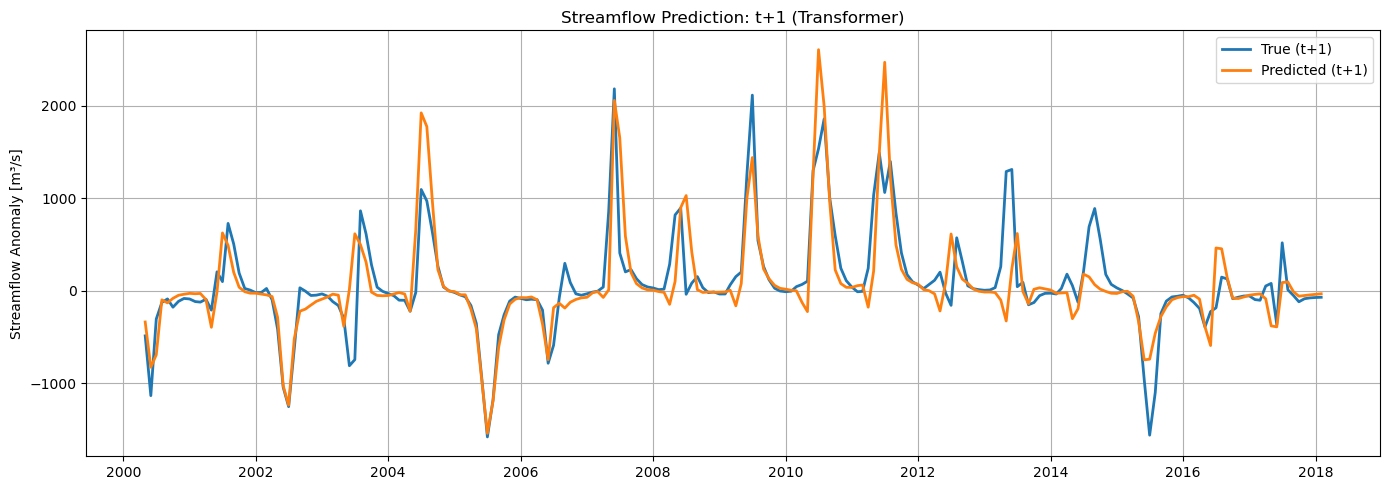

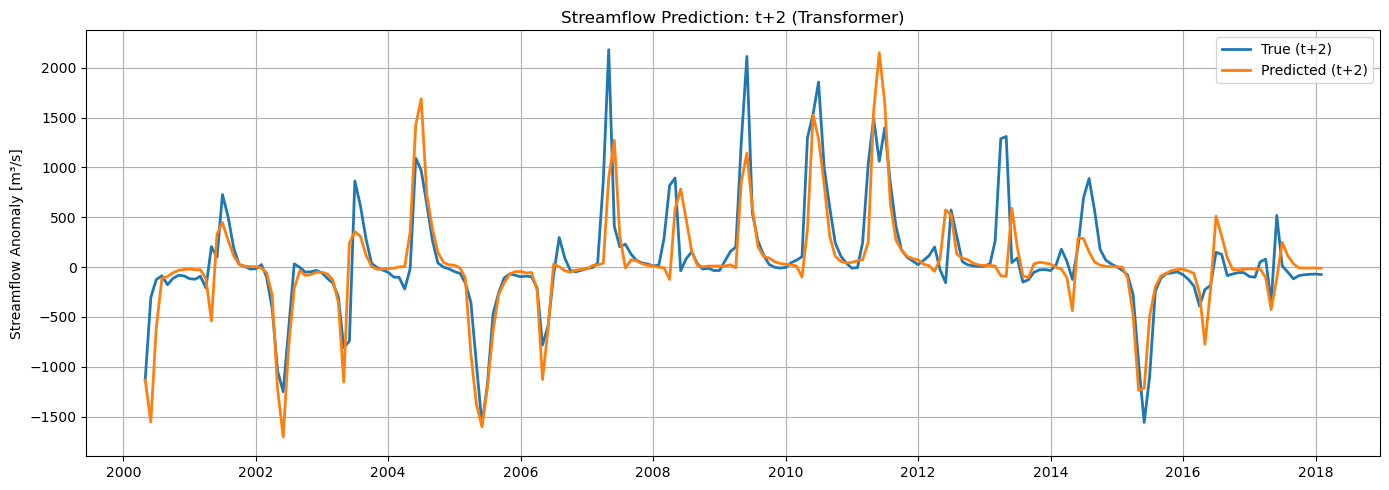

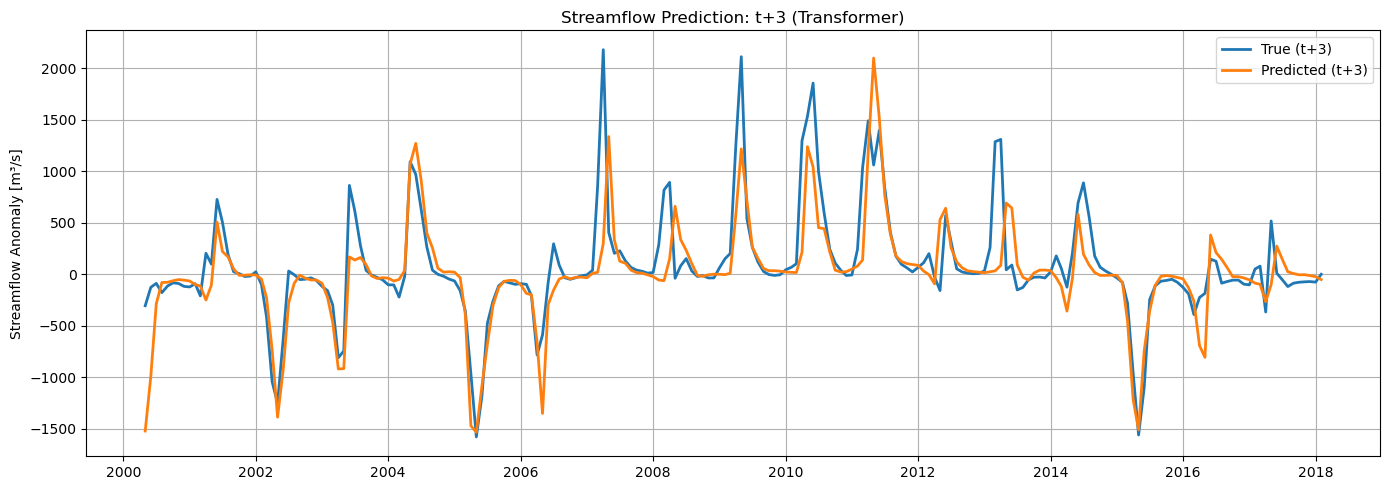

In [27]:
for month_idx in range(3):
    month_label = ['t+1', 't+2', 't+3'][month_idx]
    
    plt.figure(figsize=(14, 5))
    plt.plot(dates_test, y_true[:, month_idx], label=f'True ({month_label})', linewidth=2)
    plt.plot(dates_test, y_pred[:, month_idx], label=f'Predicted ({month_label})', linewidth=2)
    plt.ylabel("Streamflow Anomaly [m³/s]")
    plt.title(f"Streamflow Prediction: {month_label} (Transformer)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

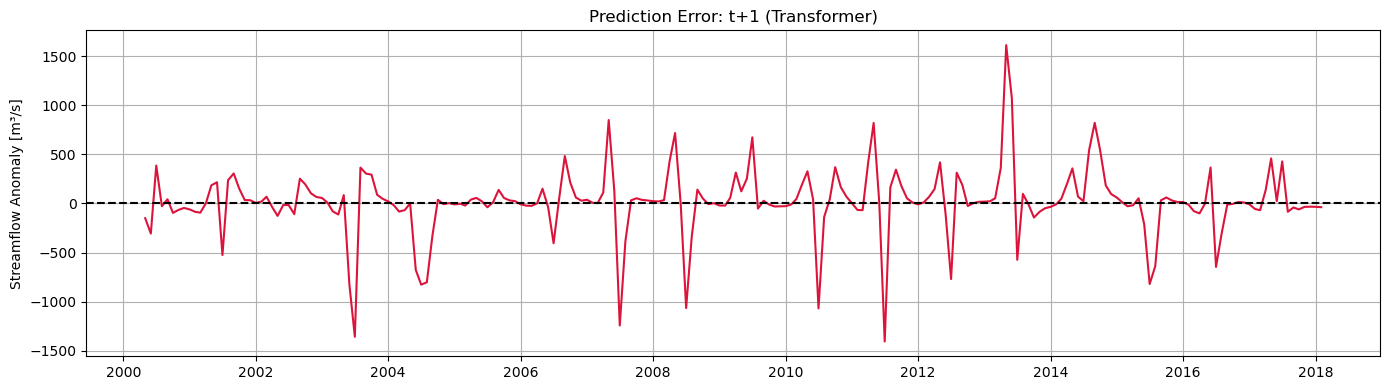

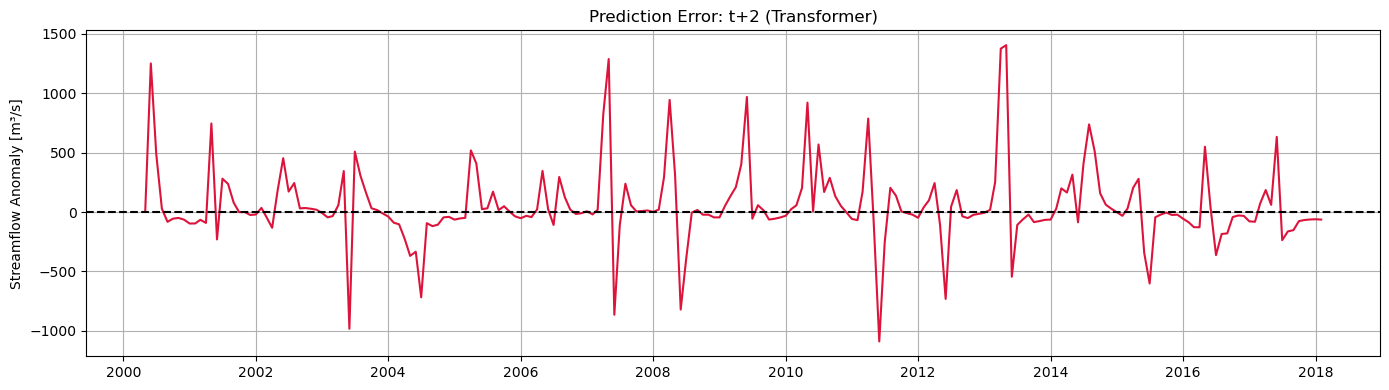

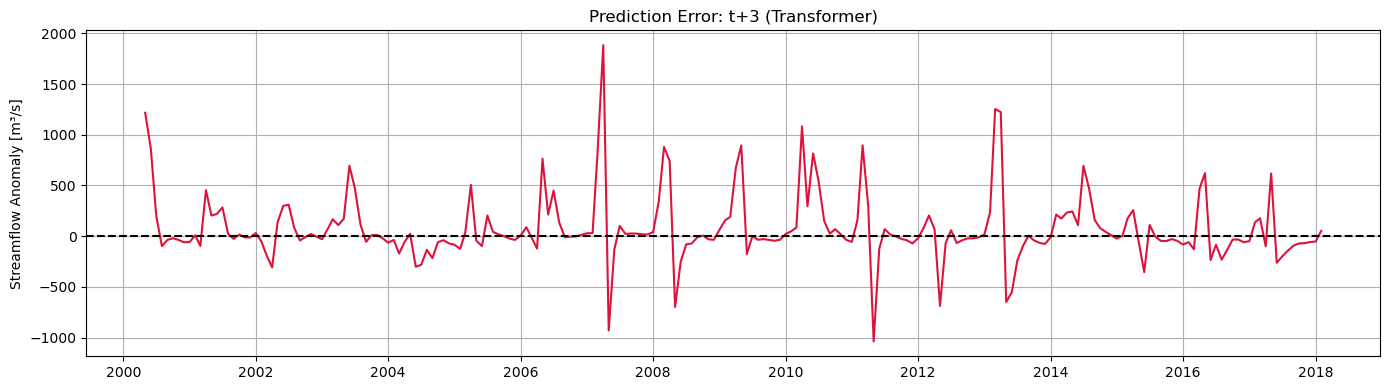

In [24]:
for month_idx in range(3):
    errors = y_true[:, month_idx] - y_pred[:, month_idx]
    
    plt.figure(figsize=(14, 4))
    plt.plot(dates_test, errors, label='Prediction Error', color='crimson')
    plt.axhline(0, linestyle='--', color='black')
    plt.ylabel("Streamflow Anomaly [m³/s]")
    plt.title(f'Prediction Error: t+{month_idx + 1} (Transformer)' )
    plt.grid(True)
    plt.tight_layout()

In [ ]:
model = build_transformer_model(window_size=36, n_features=X_train.shape[2],
                                 embed_dim=128, num_heads=4, ff_dim=256)

model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 36, 128)        │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 36, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 36, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 36, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 36, 128)        │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 992,387 (3.79 MB)

 Trainable params: 992,387 (3.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 1.5235 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.9021 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.8428 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.9004 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.7938 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.6784 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.5922 - val_loss: 0.8951 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.5206 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.4171 - val_loss: 0.4797 - learning_rate: 0.0010
Epoch 10/1


 t+1 extremes evaluation:
10th percentile threshold: -289.83
90th percentile threshold: 713.83
Mean Absolute Error (low flows)  : 263.152
Mean Absolute Error (high flows) : 564.142
Mean Absolute Error (overall)    : 186.764

 t+2 extremes evaluation:
10th percentile threshold: -270.79
90th percentile threshold: 713.83
Mean Absolute Error (low flows)  : 305.157
Mean Absolute Error (high flows) : 643.981
Mean Absolute Error (overall)    : 187.410

 t+3 extremes evaluation:
10th percentile threshold: -253.45
90th percentile threshold: 713.83
Mean Absolute Error (low flows)  : 248.714
Mean Absolute Error (high flows) : 704.132
Mean Absolute Error (overall)    : 192.637


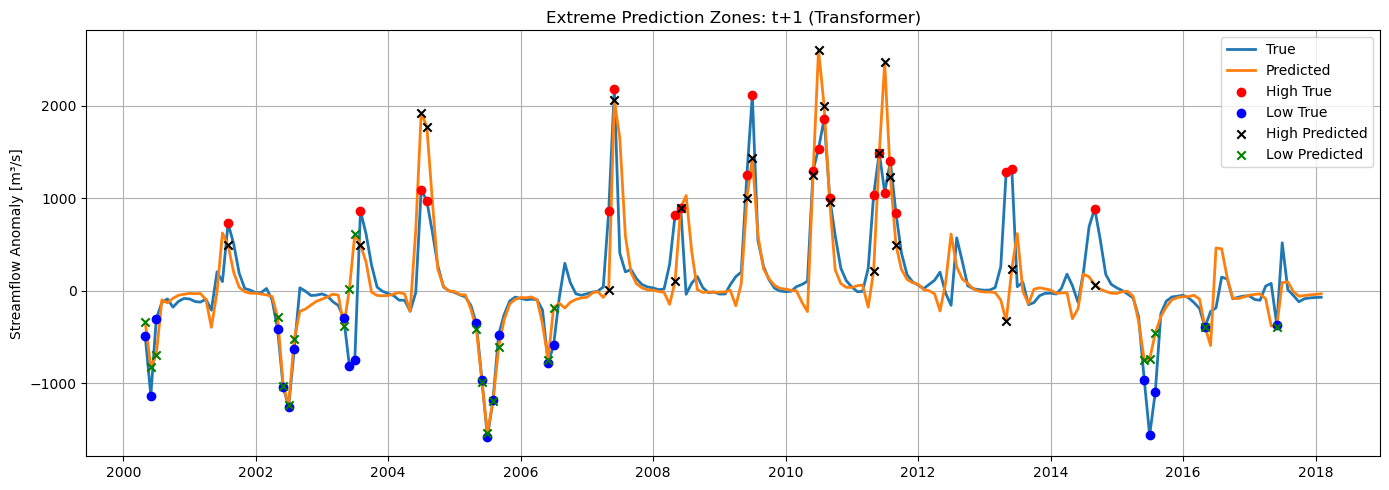

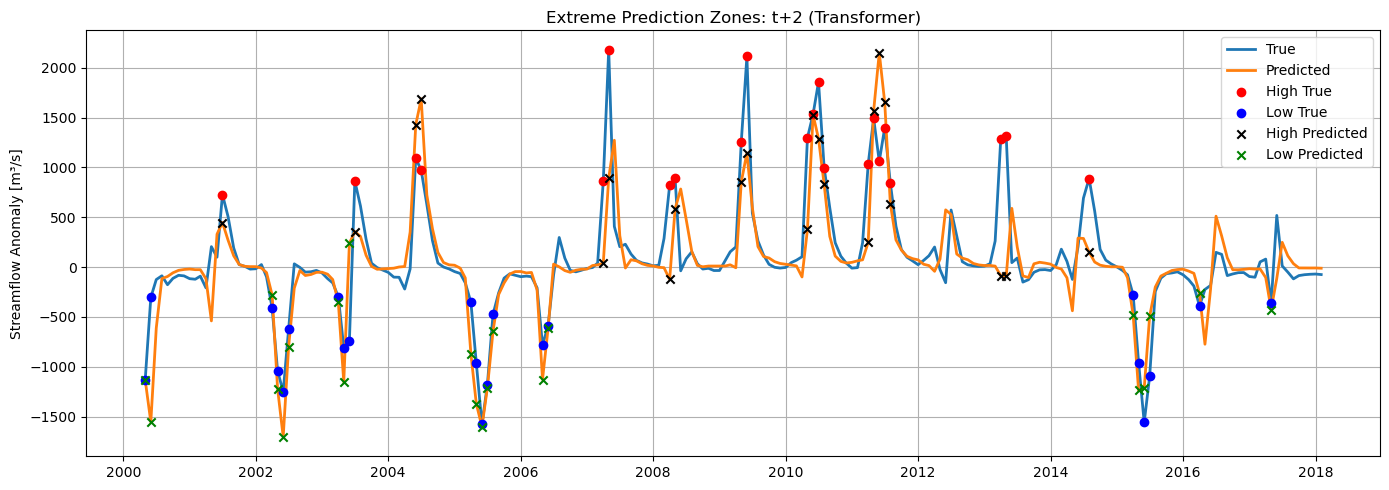

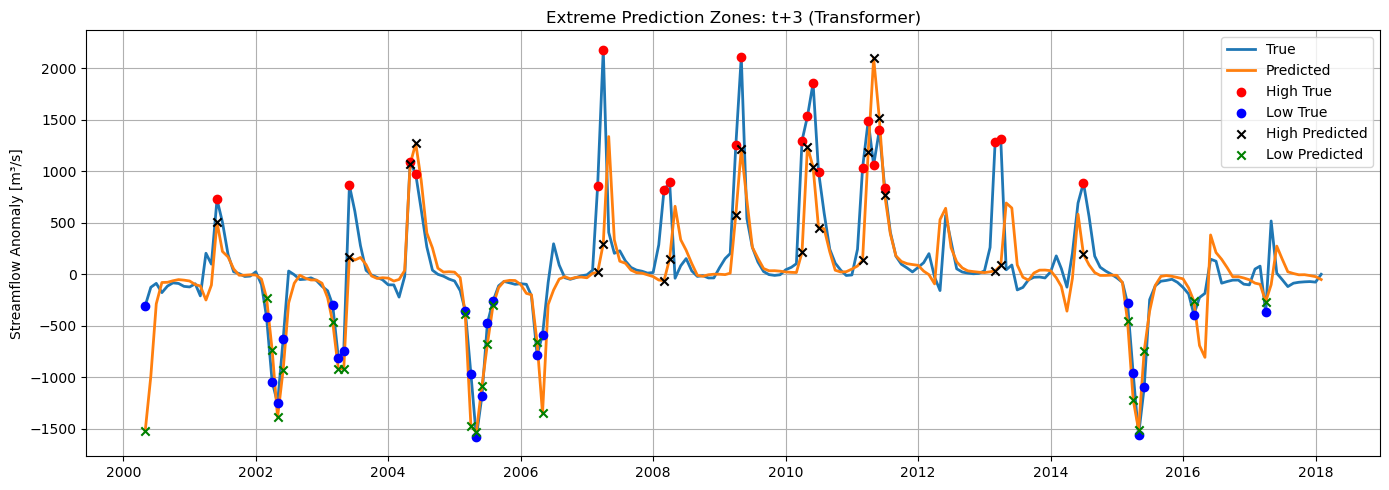

In [25]:
dates_test_np = np.array(dates_test)

for month_idx in range(3):

    low_thresh = np.percentile(y_true[:, month_idx], 10)
    high_thresh = np.percentile(y_true[:, month_idx], 90)

    low_mask = y_true[:, month_idx] < low_thresh
    high_mask = y_true[:, month_idx] > high_thresh

    low_errors = np.abs(y_pred[:, month_idx][low_mask] - y_true[:, month_idx][low_mask])
    high_errors = np.abs(y_pred[:, month_idx][high_mask] - y_true[:, month_idx][high_mask])
    all_errors = np.abs(y_pred[:, month_idx] - y_true[:, month_idx])

    print(f"\n t+{month_idx+1} extremes evaluation:")
    print(f"10th percentile threshold: {low_thresh:.2f}")
    print(f"90th percentile threshold: {high_thresh:.2f}")
    print(f"Mean Absolute Error (low flows)  : {low_errors.mean():.3f}")
    print(f"Mean Absolute Error (high flows) : {high_errors.mean():.3f}")
    print(f"Mean Absolute Error (overall)    : {all_errors.mean():.3f}")

    plt.figure(figsize=(14, 5))
    plt.plot(dates_test, y_true[:, month_idx], label='True', linewidth=2)
    plt.plot(dates_test, y_pred[:, month_idx], label='Predicted', linewidth=2)
    plt.scatter(
        dates_test_np[high_mask], y_true[:, month_idx][high_mask],
        color='red', label='High True', zorder=5)
    plt.scatter(
        dates_test_np[low_mask], y_true[:, month_idx][low_mask],
        color='blue', label='Low True', zorder=5)
    plt.scatter(
        dates_test_np[high_mask], y_pred[:, month_idx][high_mask],
        color='black', label='High Predicted', zorder=5, marker='x')

    plt.scatter(
        dates_test_np[low_mask], y_pred[:, month_idx][low_mask],
        color='green', label='Low Predicted', zorder=5, marker='x')

    plt.title(f'Extreme Prediction Zones: t+{month_idx+1} (Transformer)')
    plt.legend()
    plt.ylabel("Streamflow Anomaly [m³/s]")
    plt.grid(True)
    plt.tight_layout()
